## Predicting Patient Mortality

When patients get admitted into the ICU, what are their chances of survival? 

For doctors and caretakers in the ICU, knowing the risks of each patient helps them prioritize resources and identify patients who need more care and intervention.

In this example, we have a dataset from MIMIC III, which includes information about the patient's demographics, diagnosis, surgical procedures, vitals and lab test readings. 

Can we predict which patient is likely to survive? What information is important in making the classification?

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

### Data Exploration
- What information do we have?
- What seems to be related to our target (mortality)?

In [2]:
df = pd.read_csv('widsdatathon2020/training_v2.csv', dtype={'apache_2_diagnosis': str,
                                                            'apache_3j_diagnosis': str,
                                                           'icu_id': str})

Graphs to plot:
- Distribution of Target value

In [3]:
import seaborn as sns

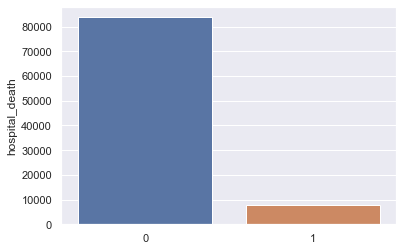

In [4]:
sns.set()

sns.barplot(df.hospital_death.unique(), df.hospital_death.value_counts())

In [5]:
df.hospital_death.value_counts(normalize=True)

0    0.913698
1    0.086302
Name: hospital_death, dtype: float64

From the barchart above, we can see that there are more than 10 times more people who survived.
In fact, 91% of patients in our dataset survived.

This means that our dataset is *highly skewed*. We will have to account for this later in our preparation steps.

In [6]:
df.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.0,...,83766.000000,83766.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,169.641588,0.835766,0.0,...,0.086787,0.043955,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,10.795378,2.487756,0.0,...,0.247569,0.217341,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,137.200000,-24.947222,0.0,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,162.500000,0.035417,0.0,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,170.100000,0.138889,0.0,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,177.800000,0.409028,0.0,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131051.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,159.090972,0.0,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Distribution of Age by mortality

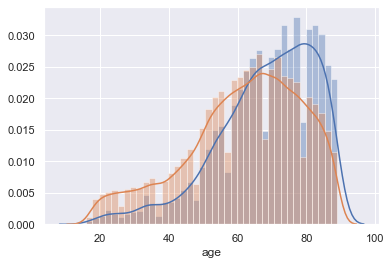

In [7]:
sns.distplot(df[(df.hospital_death == 1) & (~df.age.isna())].age, bins=40)
sns.distplot(df[(df.hospital_death == 0) & (~df.age.isna())].age, bins=40)

### Data Prep
- Handle missing values
- Handle categorical features
- Basic feature engineering

#### Fill missing values

In [10]:
from pandas.api.types import (
    is_datetime64_dtype,
    is_float_dtype,
    is_integer_dtype,
    is_numeric_dtype,
    is_object_dtype,
)

def fill_missing_vals(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Fills missing values in columns with default values specified in kwargs.

    Args:
        df: pandas dataframe
        colnames: List of columns to be filled. If None, all columns in df will be filled.
        kwargs: Modification to the default null value. It will replace the missing value defined in the __init__ file.
        The kwargs value that can be accepted is the following:
        - str_na_value
        - int_na_value
        - float_na_value
        - datetime_na_value
    Returns:
        Filled pandas dataframe
    """
    df = df.copy()

    colnames = df.columns

    for col in colnames:
        if is_object_dtype(df[col]):
            df[col] = df[col].fillna(kwargs["str_na_value"])
        elif is_integer_dtype(df[col]):
            df[col] = df[col].fillna(kwargs["int_na_value"])
        elif is_float_dtype(df[col]):
            df[col] = df[col].fillna(kwargs["float_na_value"])
    return df

In [11]:
na_vals = {'str_na_value': 'NA_VALUE',
'int_na_value': -1,
'float_na_value': -1.0}

df = fill_missing_vals(df, **na_vals)

#### Break down diagnosis codes

In [12]:
df.apache_2_diagnosis.head(5)

0    113
1    108
2    122
3    203
4    119
Name: apache_2_diagnosis, dtype: object

In [13]:
df.apache_3j_diagnosis.head(5)

0     502.01
1     203.01
2     703.03
3    1206.03
4     601.01
Name: apache_3j_diagnosis, dtype: object

From the examples of diagnosis codes above, we can get additional information from the codes. For example, the leading digit represents the group of diagnosis. We engineer theses information below:

In [72]:
# Break down diagnosis codes!
def break_down_diagnosis_codes(df):
    df['apache_2_diagnosis_group'] = df.apache_2_diagnosis.str[0]
    df['apache_3j_diagnosis_subgroup'] = df.apache_3j_diagnosis.apply(lambda x: x.split(".")[0])
    df['apache_3j_diagnosis_group'] = df.apache_3j_diagnosis.str[0]
    
    df['apache_2_diagnosis_group'] = df['apache_2_diagnosis_group'].replace('N', -1).astype(int)
    df['apache_3j_diagnosis_subgroup'] = df['apache_3j_diagnosis_subgroup'].replace('NA_VALUE', -1).astype(int)
    df['apache_3j_diagnosis_group'] = df['apache_3j_diagnosis_group'].replace('N', -1).astype(int)
    
    return df

In [73]:
df = break_down_diagnosis_codes(df)

#### Calculate glasgow scale
The glasgow scale is given by the sum of the verbal, eyes and motor score. Since this is not calculated in the dataset, we will calculate it below:

In [16]:
df['glasgow_scale'] = np.where(df['gcs_unable_apache'] == 0,
                               df[['gcs_verbal_apache', 'gcs_eyes_apache', 'gcs_motor_apache']].sum(axis=1),
                               -1)

#### Handle categorical features

Order the admission source based on the % of patients in each category that does not survive.
Below, admission from 'Observation' is given a rank of 11 because all paitents from Observation survived.
In contrast, admission from 'Other', 'SDU', amd 'Other ICU' are given the top 3 ranks because a higher proportion of patients from each of the 3 groups did not survive.

In [17]:
admit_source_order = {'Other': 1,
                      'Step-Down Unit (SDU)': 2,
                     'Other ICU': 3,
                     'Floor': 4,
                     'Other Hospital': 4,
                     'Acute Care/Floor': 5,
                     'Direct Admit': 5,
                     'Emergency Department': 6,
                     'ICU': 7,
                     'NA_VALUE': -1,
                     'ICU to SDU': 9,
                     'Chest Pain Center': 8,
                     'Recovery Room': 10,
                     'Operating Room': 10,
                     'PACU': 10,
                     'Observation': 11}

Simiarly, we give a rank for the ICU category. Those in CSICU (Cardiac Surgery ICU) are given the highest rank of 6 because they more likely to survive. In contrast, those in MICU (Medical ICU) are given the top rank because they are less likely to survive.

In [18]:
icu_order = {'MICU': 1,
            'Cardiac ICU': 2,
            'Med-Surg ICU': 3,
            'Neuro ICU': 3,
            'CCU-CTICU': 4,
            'SICU': 4,
            'CTICU': 5,
            'CSICU': 6}

We will replace the categories with their ranked value, and also remove all cases under 'Observation' because they will all survive.

In [19]:
df.icu_type = df.icu_type.replace(icu_order)
df.hospital_admit_source = df.hospital_admit_source.replace(admit_source_order)

In [20]:
df = df[df.hospital_admit_source != 11]

#### Drop correlated features

In [21]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [22]:
to_drop

['paco2_for_ph_apache',
 'ph_apache',
 'd1_mbp_invasive_min',
 'd1_sysbp_invasive_max',
 'd1_sysbp_invasive_min',
 'd1_temp_min',
 'h1_diasbp_invasive_min',
 'h1_mbp_invasive_min',
 'h1_spo2_min',
 'h1_sysbp_invasive_max',
 'h1_sysbp_invasive_min',
 'h1_temp_min',
 'd1_albumin_min',
 'd1_bilirubin_min',
 'd1_bun_min',
 'd1_calcium_min',
 'd1_creatinine_min',
 'd1_hco3_min',
 'd1_hemaglobin_min',
 'd1_hematocrit_max',
 'd1_hematocrit_min',
 'd1_inr_min',
 'd1_platelets_min',
 'd1_potassium_min',
 'd1_sodium_min',
 'h1_albumin_min',
 'h1_bilirubin_min',
 'h1_bun_min',
 'h1_calcium_min',
 'h1_creatinine_min',
 'h1_glucose_min',
 'h1_hco3_min',
 'h1_hemaglobin_min',
 'h1_hematocrit_min',
 'h1_inr_max',
 'h1_inr_min',
 'h1_lactate_min',
 'h1_platelets_min',
 'h1_potassium_min',
 'h1_sodium_min',
 'h1_wbc_min',
 'd1_arterial_pco2_min',
 'd1_arterial_ph_min',
 'h1_arterial_pco2_min',
 'h1_arterial_ph_min',
 'h1_pao2fio2ratio_min',
 'apache_4a_icu_death_prob']

In [23]:
df = df.drop(columns=to_drop)

#### Remove ID columns

In [25]:
id_cols = ['encounter_id', 'patient_id']
df = df.drop(columns=id_cols)

#### Remove biased columns

In [26]:
biased_cols = ['ethnicity', 'gender']
df = df.drop(columns = biased_cols)

### Train-Validation Split

In [75]:
train, val = train_test_split(df, test_size=0.2, random_state=21)

In [76]:
# train.to_csv('widsdatathon2020/train.csv', index=False)
# val.to_csv('widsdatathon2020/val.csv', index=False)

### Feature Encoding

In [77]:
# from catalyst.feat_eng.encoder.label import fit_label, transform_label
from category_encoders.one_hot import OneHotEncoder, OrdinalEncoder

In [78]:
one_hot_cols = ['icu_admit_source',
 'icu_stay_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [79]:
train.icu_id = train.icu_id.astype(int)
val.icu_id = val.icu_id.astype(int)

In [80]:
# One-hot Encode
oh_encoder = OneHotEncoder(cols = one_hot_cols, use_cat_names=True)
oh_encoder.fit(train)
train_encoded = oh_encoder.transform(train)
val_encoded = oh_encoder.transform(val)

In [81]:
train_encoded.apache_2_diagnosis = train_encoded.apache_2_diagnosis.replace('NA_VALUE', -1).astype(int)
val_encoded.apache_2_diagnosis = val_encoded.apache_2_diagnosis.replace('NA_VALUE', -1).astype(int)

train_encoded.apache_3j_diagnosis = train_encoded.apache_3j_diagnosis.replace('NA_VALUE', -1).astype(float)
val_encoded.apache_3j_diagnosis = val_encoded.apache_3j_diagnosis.replace('NA_VALUE', -1).astype(float)

In [82]:
# train_encoded.to_csv('widsdatathon2020/train_encoded.csv', index=False)
# val_encoded.to_csv('widsdatathon2020/val_encoded.csv', index=False)

### Train and validate model
- Maybe Kfold Cross Val?

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def add_perc(x, total) -> str:
    """
    Calculates percentage score of x and return as string in format: "x (perc%)"
    Args:
        x: x-value
        total: Total sum of x-values

    Returns: String including percentage score.

    """
    perc = x*100/total
    perc = round(perc, 2)
    return '{0} ({1}%)'.format(str(x), str(perc))


def get_matrix_annot(matrix: np.array) -> np.array:
    """
    Gets annotations (of percentage scores) for confusion matrix.
    Args:
        matrix: numpy array of confusion matrix

    Returns: numpy array of annotations for the matrix.

    """
    df = pd.DataFrame(data=matrix)
    columns = list(df)
    for col in columns:
        df[col] = df[col].apply(lambda x: add_perc(x, matrix.sum()))
    return df.values

def plot_confusion_matrix(actual: np.array, predicted: np.array, path: str = None) -> None:
    """
    Plot a confusion matrix heatmap.
    Args:
        actual: Numpy array of actual target values
        predicted: Numpy array of model predicted values
        path: File name of plot to save. Shows plot if unspecified. Defaults to none.

    Returns: None - Saves plot as png if path is specified. Otherwise, shows plot.

    """
    fig, ax = plt.subplots(figsize=(15, 5))
    # Get values for confusion matrix
    matrix = confusion_matrix(actual, predicted)
    annotation = get_matrix_annot(matrix)
    plot = sns.heatmap(matrix, annot=annotation, fmt='', ax=ax, cmap='RdBu')
    plot.set(title='Confusion Matrix', ylabel='Actual Label', xlabel='Predicted Label')
    fig.show()

In [85]:
TARGET = 'hospital_death'

X_train = train_encoded.drop(columns=[TARGET])
X_val = val_encoded.drop(columns=[TARGET])

y_train = train_encoded[TARGET]
y_val = val_encoded[TARGET]

In [86]:
model = LGBMClassifier(class_weight='balanced', objective='binary', 
#                        **best_params
                      )

X_train.hospital_admit_source = X_train.hospital_admit_source.replace(-1, 0)
X_val.hospital_admit_source = X_val.hospital_admit_source.replace(-1, 0)

model.fit(X_train, y_train)

pred_proba = model.predict_proba(X_val)

roc_auc_score(y_val, pred_proba[:, 1])

0.9061372127429635

In [87]:
y_pred = model.predict(X_val)
accuracy_score(y_val, y_pred)

0.8433564145902622

/Users/wenqing/Documents/wids2020/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


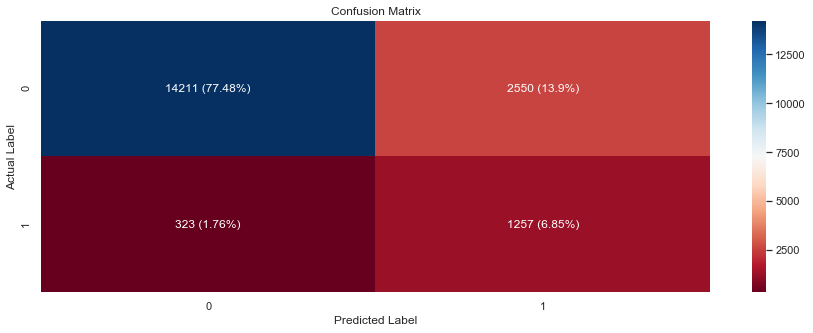

In [88]:
plot_confusion_matrix(y_val, y_pred)

### Feature Importance

In [89]:
from lightgbm import plot_importance

In [90]:
feat_impt = pd.DataFrame()
feat_impt['feature_name'] = X_train.columns
# In LGBM, the feature importance is represented by the number of times the feature is used.
feat_impt['importance'] = model.feature_importances_

In [91]:
top_features = feat_impt[feat_impt.importance > 0].feature_name.tolist()

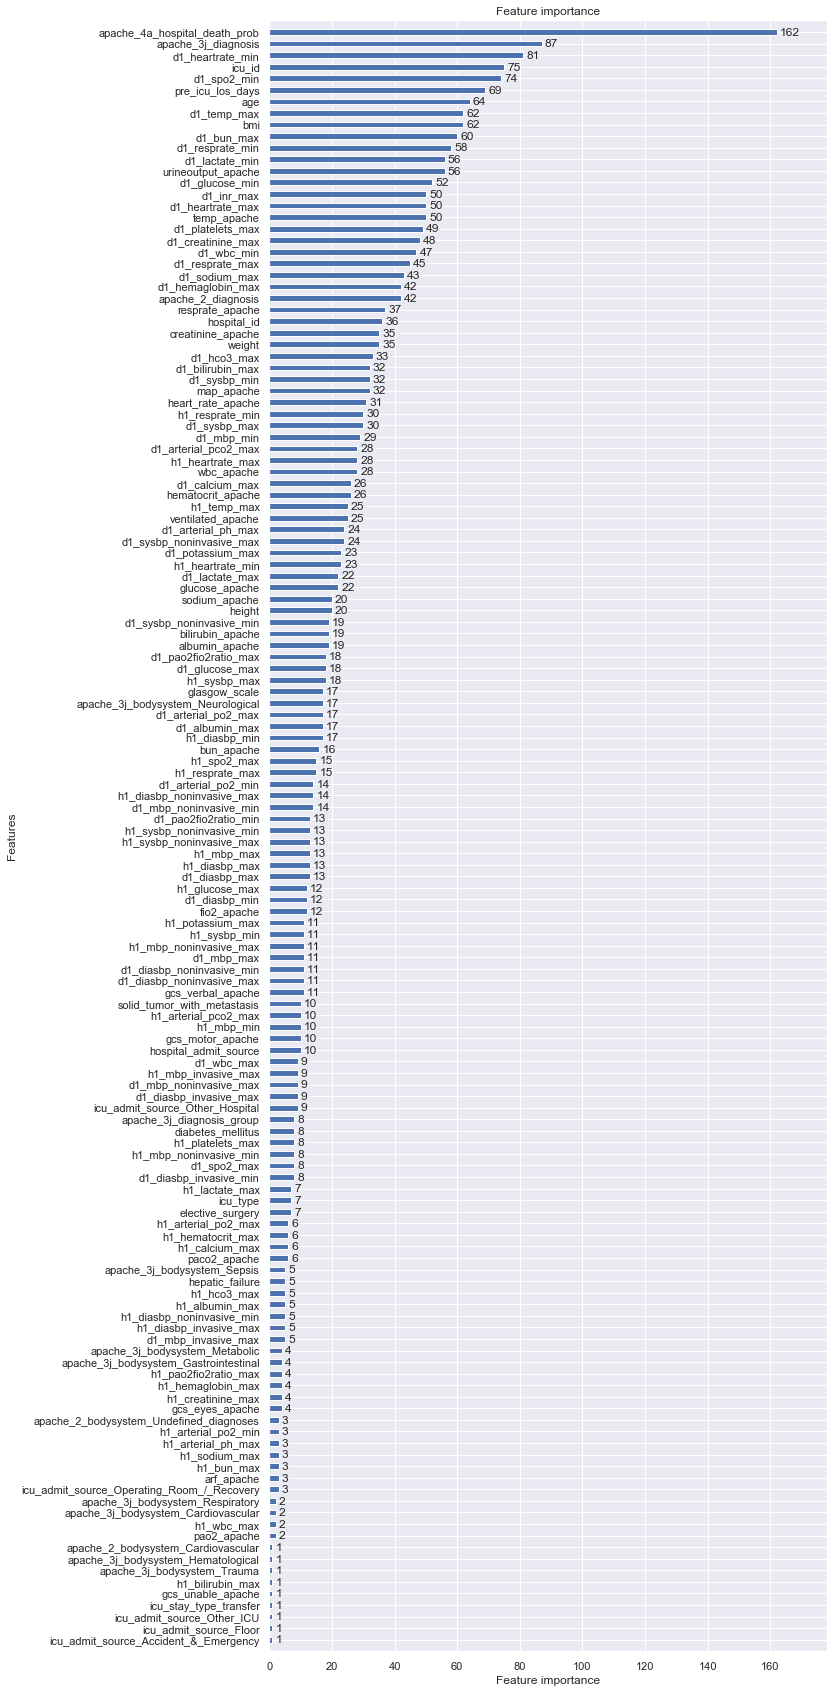

In [92]:
plot_importance(model, height=0.5, figsize=(10, 30))

### Remove useless features

In [93]:
model = LGBMClassifier(class_weight='balanced', objective='binary', 
#                        **best_params
                      )

X_train.hospital_admit_source = X_train.hospital_admit_source.replace(-1, 0)
X_val.hospital_admit_source = X_val.hospital_admit_source.replace(-1, 0)

model.fit(X_train[top_features], y_train)

pred_proba = model.predict_proba(X_val[top_features])

roc_auc_score(y_val, pred_proba[:, 1])

0.9061372127429635

In [94]:
y_pred = model.predict(X_val[top_features])
accuracy_score(y_val, y_pred)

0.8433564145902622

/Users/wenqing/Documents/wids2020/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


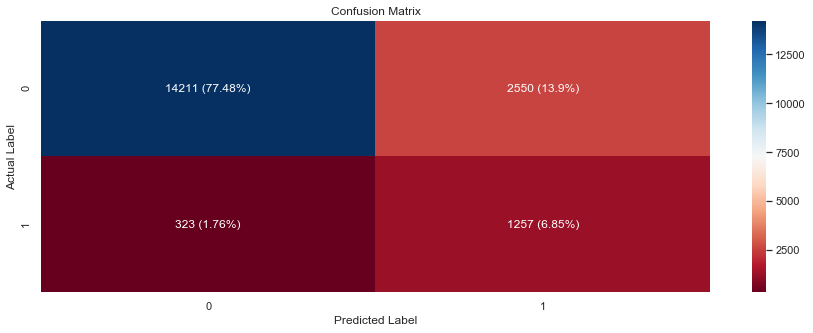

In [95]:
plot_confusion_matrix(y_val, y_pred)

#### Remove influence from `apache_4a_hospital_death_prob`

In [96]:
top_features.remove('apache_4a_hospital_death_prob')

In [97]:
model = LGBMClassifier(class_weight='balanced', objective='binary', 
#                        **best_params
                      )

X_train.hospital_admit_source = X_train.hospital_admit_source.replace(-1, 0)
X_val.hospital_admit_source = X_val.hospital_admit_source.replace(-1, 0)

model.fit(X_train[top_features], y_train)

pred_proba = model.predict_proba(X_val[top_features])

roc_auc_score(y_val, pred_proba[:, 1])

0.9082043985472604

In [98]:
y_pred = model.predict(X_val[top_features])
accuracy_score(y_val, y_pred)

0.8430838013194483

/Users/wenqing/Documents/wids2020/env/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


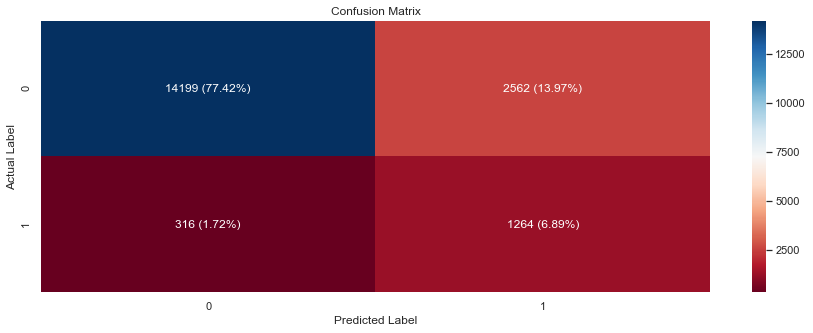

In [99]:
plot_confusion_matrix(y_val, y_pred)

### Package Model
- Train model on full data

In [127]:
def feat_encoding(df):
        df.icu_id = df.icu_id.astype(int)

        # One-hot Encode
        oh_encoder = OneHotEncoder(cols = one_hot_cols, use_cat_names=True)
        oh_encoder.fit(df)
        df_encoded = oh_encoder.transform(df)

        df_encoded.apache_2_diagnosis = df_encoded.apache_2_diagnosis.replace('NA_VALUE', -1).astype(int)
        df_encoded.apache_3j_diagnosis = df_encoded.apache_3j_diagnosis.replace('NA_VALUE', -1).astype(float)

        return oh_encoder, df_encoded

In [128]:
oh_encoder, df_encoded = feat_encoding(df)
# df_encoded = df_encoded[top_features]

In [105]:
X_df = df_encoded.drop(columns=[TARGET])
X_df = X_df[top_features]
y_df = df_encoded[[TARGET]]

In [106]:
y_df.hospital_death.value_counts(normalize=True)

0    0.913689
1    0.086311
Name: hospital_death, dtype: float64

In [107]:
X_df.hospital_admit_source = X_df.hospital_admit_source.replace(-1, 0)

In [108]:
model = LGBMClassifier(class_weight='balanced', objective='binary')

model.fit(X_df, y_df)

/Users/wenqing/Documents/wids2020/env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wenqing/Documents/wids2020/env/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### Create Predictor Class

In [198]:
class MortalityPredictor:
    def __init__(self, corr_feats_to_drop, one_hot_encoder, top_features):
        self.model = None
        self.input = None
        
        self.one_hot_encoder = one_hot_encoder
        self.corr_feats_to_drop = corr_feats_to_drop
        self.top_features = top_features
        
    def data_prep(self):
        df = self.input.copy()
        
        print("===== Starting data prep, shape: {}".format(df.shape))
        
        # Fill Missing Vals
#         na_vals = {'str_na_value': 'NA_VALUE',
#         'int_na_value': -1,
#         'float_na_value': -1.0}

        df = df.fillna(-1)
        print("Filled missing values, shape: {}".format(df.shape))
        
        df = df.drop(columns=id_cols)
        print("Dropped ID columns, shape: {}".format(df.shape))

        df = df.drop(columns=biased_cols)
        print("Dropped biased columns, shape: {}".format(df.shape))

        return df
    
    def feat_eng(self, df):
        
        print("===== Starting feat eng, shape: {}".format(df.shape))
        # Break down diagnosis codes
        df = break_down_diagnosis_codes(df)

        print("Break down diagnosis codes, shape: {}".format(df.shape))

        # Calculate glasgow scale
        df['glasgow_scale'] = np.where(df['gcs_unable_apache'] == 0,
                                   df[['gcs_verbal_apache', 'gcs_eyes_apache', 'gcs_motor_apache']].sum(axis=1),
                                   -1)
        print("Calculate glasgow scale, shape: {}".format(df.shape))

        # Handle categorical variables
        df['icu_type'] = df.icu_type.replace(icu_order).astype(int)
        df['hospital_admit_source'] = df.hospital_admit_source.replace(admit_source_order).astype(int)
        
        df = df[df.hospital_admit_source != 11]
        
        print("Handle categorical variables, shape: {}".format(df.shape))

        # Drop correlated features
        df = df.drop(columns=self.corr_feats_to_drop)
        print("Dropped correlated features, shape: {}".format(df.shape))
        
        return df
    
    def feat_encoding(self, df):
        print("===== Encoding features, shape: {}".format(df.shape))
        df.icu_id = df.icu_id.astype(int)

        # One-hot Encode
        df_encoded = self.one_hot_encoder.transform(df)

        df_encoded.apache_2_diagnosis = df_encoded.apache_2_diagnosis.replace('NA_VALUE', -1).astype(int)
        df_encoded.apache_3j_diagnosis = df_encoded.apache_3j_diagnosis.replace('NA_VALUE', -1).astype(float)
        
        print("One-hot encoded features, shape: {}".format(df_encoded.shape))
        
        return df_encoded
    
    def predict(self, input_json):
        self.input = input_json
        df = self.data_prep()
        df = self.feat_eng(df)
        df = self.feat_encoding(df)
        
        pred = self.model.predict(df[self.top_features])
        
        return {"result": pred[0]}

### Test Predictor Class
- dummy input
- Check prediction

In [202]:
predictor = MortalityPredictor(corr_feats_to_drop=to_drop, 
                               one_hot_encoder=oh_encoder,
                              top_features=top_features)

In [203]:
predictor.model = model

In [114]:
# test = pd.read_csv('widsdatathon2020/unlabeled.csv', dtype={'apache_2_diagnosis': str,
#                                                             'apache_3j_diagnosis': str,
#                                                            'icu_id': str})

In [199]:
survive_input = """{"encounter_id": 2,
 "patient_id": 127112,
 "hospital_id": 7,
 "hospital_death": null,
 "age": 56.0,
 "bmi": 21.10243942,
 "elective_surgery": 0,
 "ethnicity": "Caucasian",
 "gender": "M",
 "height": 180.3,
 "hospital_admit_source": "Emergency Department",
 "icu_admit_source": "Accident & Emergency",
 "icu_id": "1105",
 "icu_stay_type": "admit",
 "icu_type": "Neuro ICU",
 "pre_icu_los_days": 0.10416666699999999,
 "readmission_status": 0,
 "weight": 68.6,
 "albumin_apache": 3.7,
 "apache_2_diagnosis": "301",
 "apache_3j_diagnosis": "405.01",
 "apache_post_operative": 0,
 "arf_apache": 0.0,
 "bilirubin_apache": null,
 "bun_apache": 19.0,
 "creatinine_apache": 0.67,
 "fio2_apache": null,
 "gcs_eyes_apache": 2.0,
 "gcs_motor_apache": 5.0,
 "gcs_unable_apache": 0.0,
 "gcs_verbal_apache": 1.0,
 "glucose_apache": 276.0,
 "heart_rate_apache": 105.0,
 "hematocrit_apache": 42.0,
 "intubated_apache": 0.0,
 "map_apache": 57.0,
 "paco2_apache": null,
 "paco2_for_ph_apache": null,
 "pao2_apache": null,
 "ph_apache": null,
 "resprate_apache": 5.0,
 "sodium_apache": 134.0,
 "temp_apache": 36.6,
 "urineoutput_apache": 1121.1264,
 "ventilated_apache": 0.0,
 "wbc_apache": 4.7,
 "d1_diasbp_invasive_max": null,
 "d1_diasbp_invasive_min": null,
 "d1_diasbp_max": 74.0,
 "d1_diasbp_min": 51.0,
 "d1_diasbp_noninvasive_max": 74.0,
 "d1_diasbp_noninvasive_min": 51.0,
 "d1_heartrate_max": 100.0,
 "d1_heartrate_min": 78.0,
 "d1_mbp_invasive_max": null,
 "d1_mbp_invasive_min": null,
 "d1_mbp_max": 86.0,
 "d1_mbp_min": 60.0,
 "d1_mbp_noninvasive_max": 86.0,
 "d1_mbp_noninvasive_min": 60.0,
 "d1_resprate_max": 20.0,
 "d1_resprate_min": 8.0,
 "d1_spo2_max": 100.0,
 "d1_spo2_min": 96.0,
 "d1_sysbp_invasive_max": null,
 "d1_sysbp_invasive_min": null,
 "d1_sysbp_max": 121.0,
 "d1_sysbp_min": 79.0,
 "d1_sysbp_noninvasive_max": 121.0,
 "d1_sysbp_noninvasive_min": 79.0,
 "d1_temp_max": 37.1,
 "d1_temp_min": 36.6,
 "h1_diasbp_invasive_max": null,
 "h1_diasbp_invasive_min": null,
 "h1_diasbp_max": 55.0,
 "h1_diasbp_min": 51.0,
 "h1_diasbp_noninvasive_max": 55.0,
 "h1_diasbp_noninvasive_min": 51.0,
 "h1_heartrate_max": 88.0,
 "h1_heartrate_min": 84.0,
 "h1_mbp_invasive_max": null,
 "h1_mbp_invasive_min": null,
 "h1_mbp_max": 68.0,
 "h1_mbp_min": 60.0,
 "h1_mbp_noninvasive_max": 68.0,
 "h1_mbp_noninvasive_min": 60.0,
 "h1_resprate_max": 18.0,
 "h1_resprate_min": 8.0,
 "h1_spo2_max": 100.0,
 "h1_spo2_min": 98.0,
 "h1_sysbp_invasive_max": null,
 "h1_sysbp_invasive_min": null,
 "h1_sysbp_max": 91.0,
 "h1_sysbp_min": 79.0,
 "h1_sysbp_noninvasive_max": 91.0,
 "h1_sysbp_noninvasive_min": 79.0,
 "h1_temp_max": 36.6,
 "h1_temp_min": 36.6,
 "d1_albumin_max": 3.7,
 "d1_albumin_min": 3.7,
 "d1_bilirubin_max": null,
 "d1_bilirubin_min": null,
 "d1_bun_max": 19.0,
 "d1_bun_min": 19.0,
 "d1_calcium_max": 9.3,
 "d1_calcium_min": 9.3,
 "d1_creatinine_max": 0.67,
 "d1_creatinine_min": 0.67,
 "d1_glucose_max": 276.0,
 "d1_glucose_min": 167.0,
 "d1_hco3_max": 24.0,
 "d1_hco3_min": 24.0,
 "d1_hemaglobin_max": 13.8,
 "d1_hemaglobin_min": 13.8,
 "d1_hematocrit_max": 42.0,
 "d1_hematocrit_min": 42.0,
 "d1_inr_max": null,
 "d1_inr_min": null,
 "d1_lactate_max": null,
 "d1_lactate_min": null,
 "d1_platelets_max": 223.0,
 "d1_platelets_min": 223.0,
 "d1_potassium_max": 4.8,
 "d1_potassium_min": 4.8,
 "d1_sodium_max": 135.0,
 "d1_sodium_min": 134.0,
 "d1_wbc_max": 4.7,
 "d1_wbc_min": 4.7,
 "h1_albumin_max": null,
 "h1_albumin_min": null,
 "h1_bilirubin_max": null,
 "h1_bilirubin_min": null,
 "h1_bun_max": null,
 "h1_bun_min": null,
 "h1_calcium_max": null,
 "h1_calcium_min": null,
 "h1_creatinine_max": null,
 "h1_creatinine_min": null,
 "h1_glucose_max": null,
 "h1_glucose_min": null,
 "h1_hco3_max": null,
 "h1_hco3_min": null,
 "h1_hemaglobin_max": null,
 "h1_hemaglobin_min": null,
 "h1_hematocrit_max": null,
 "h1_hematocrit_min": null,
 "h1_inr_max": null,
 "h1_inr_min": null,
 "h1_lactate_max": null,
 "h1_lactate_min": null,
 "h1_platelets_max": null,
 "h1_platelets_min": null,
 "h1_potassium_max": null,
 "h1_potassium_min": null,
 "h1_sodium_max": null,
 "h1_sodium_min": null,
 "h1_wbc_max": null,
 "h1_wbc_min": null,
 "d1_arterial_pco2_max": null,
 "d1_arterial_pco2_min": null,
 "d1_arterial_ph_max": null,
 "d1_arterial_ph_min": null,
 "d1_arterial_po2_max": null,
 "d1_arterial_po2_min": null,
 "d1_pao2fio2ratio_max": null,
 "d1_pao2fio2ratio_min": null,
 "h1_arterial_pco2_max": null,
 "h1_arterial_pco2_min": null,
 "h1_arterial_ph_max": null,
 "h1_arterial_ph_min": null,
 "h1_arterial_po2_max": null,
 "h1_arterial_po2_min": null,
 "h1_pao2fio2ratio_max": null,
 "h1_pao2fio2ratio_min": null,
 "apache_4a_hospital_death_prob": 0.13,
 "apache_4a_icu_death_prob": 0.08,
 "aids": 0.0,
 "cirrhosis": 0.0,
 "diabetes_mellitus": 0.0,
 "hepatic_failure": 0.0,
 "immunosuppression": 0.0,
 "leukemia": 0.0,
 "lymphoma": 0.0,
 "solid_tumor_with_metastasis": 0.0,
 "apache_3j_bodysystem": "Neurological",
 "apache_2_bodysystem": "Neurologic"}"""

In [204]:
import json

In [205]:
predictor.predict(pd.DataFrame(json.loads(survive_input), index=[0]))

===== Starting data prep, shape: (1, 186)
Filled missing values, shape: (1, 186)
Dropped ID columns, shape: (1, 184)
Dropped biased columns, shape: (1, 182)
===== Starting feat eng, shape: (1, 182)
Break down diagnosis codes, shape: (1, 185)
Calculate glasgow scale, shape: (1, 186)
Handle categorical variables, shape: (1, 186)
Dropped correlated features, shape: (1, 139)
===== Encoding features, shape: (1, 139)
One-hot encoded features, shape: (1, 167)


{'result': 0}

### Publish Predictor